In [10]:
# 导包
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader  # 用於創建數據加載器的模塊
import torch.optim as opt  # PyTorch的優化器模塊

In [3]:

# device = torch.device("cuda:0")   # 指定GPU编号
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) # cuda:0


cuda:0


In [4]:
print(torch.__version__)
print(torch.cuda.is_available())


2.5.0+cu124
True


In [29]:

transform = transforms.Compose(
    [transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#進行標準化

# 在torchvision中下载CIFAR10的数据集(训练集和测试集)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# 10种图片的类别 classes是tuple
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Files already downloaded and verified
Files already downloaded and verified


[[[0.5        0.5        0.5        ... 0.5        0.5        0.5       ]
  [0.5        0.5        0.5        ... 0.5        0.5        0.5       ]
  [0.5        0.5        0.87058824 ... 0.32941177 0.5        0.5       ]
  ...
  [0.5        0.5        0.3529412  ... 0.03529412 0.5        0.5       ]
  [0.5        0.5        0.5        ... 0.5        0.5        0.5       ]
  [0.5        0.5        0.5        ... 0.5        0.5        0.5       ]]

 [[0.5        0.5        0.5        ... 0.5        0.5        0.5       ]
  [0.5        0.5        0.5        ... 0.5        0.5        0.5       ]
  [0.5        0.5        0.81960785 ... 0.42745098 0.5        0.5       ]
  ...
  [0.5        0.5        0.30980393 ... 0.06666666 0.5        0.5       ]
  [0.5        0.5        0.5        ... 0.5        0.5        0.5       ]
  [0.5        0.5        0.5        ... 0.5        0.5        0.5       ]]

 [[0.5        0.5        0.5        ... 0.5        0.5        0.5       ]
  [0.5        0.5     

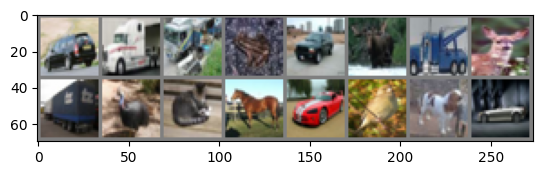

  car


In [28]:
# 随机选出4张图
import matplotlib.pyplot as plt
import numpy as np
# 定义函数-> 显示图片
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    print(npimg)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# 随机获取训练集中的图片
dataiter = iter(trainloader)
images, labels = next(dataiter)
# 调用函数显示图片
imshow(torchvision.utils.make_grid(images))
# 显示图片对应的标签labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 定義卷積層序列
        self.conv_layers = nn.Sequential(
            # in_channels=1，代表圖片是灰階，如果是RGB彩色則是3。out_channels可以改變，如16、32...
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 這裡的in_channels要與前一層的conv的輸出對應，out_channels同樣也可以改變。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            # 對整個特徵圖進行壓縮，從28*28變成14*14
            nn.MaxPool2d(stride=2, kernel_size=2)
        )
        # 定義全連接層序列
        self.dense = nn.Sequential(
            # in_features = 卷積池化後的輸出特徵圖大小，out_features同樣也可以進行修改
            nn.Linear(in_features=16*16*128, out_features=1024),
            nn.ReLU(),
            # 1024 = 前面全連接層的輸出，10 = out_features，代表分類的數量
            nn.Linear(1024, 10)
        )
    # 前向傳播  
    def forward(self, x):
        output = self.conv_layers(x)        # 輸入一張圖x，透過卷積層產生特徵圖
        output = output.view(-1, 16*16*128) # 將卷積層的輸出展平成一維向量。-1表示這個向量的大小會被自動計算以滿足其他維度的元素數目不變。展平後的維度=(batch_size,14*14*128)
        output = self.dense(output)         # 將展平後的向量透過全連接層進行前向傳播，得到模型的輸出。
        return output  
    
net = Net()
net = net.to(device)  # 上传到GPU 
print(net) 


Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=32768, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [17]:


# 超參數
learning_rate = 0.0001  # 學習率

# 定義損失函數
loss_func = nn.CrossEntropyLoss()

# 定義優化器
optimizer = opt.Adam(net.parameters(), lr=learning_rate)

# 超參數
num_epochs = 2  # 訓練的總共遍歷數據的次數

# 訓練迴圈
for epoch in range(num_epochs):
    for idx, (images, labels) in enumerate(trainloader):
        # 將數據移至GPU（如果可用）
        images = images.to(device)
        labels = labels.to(device)

        # 梯度清零
        optimizer.zero_grad()

        # 前向傳播
        outputs = net(images)

        # 計算損失
        loss = loss_func(outputs, labels)

        # 反向傳播和優化
        loss.backward()
        optimizer.step()

        # 每1000個批次印出訓練過程中的損失
        if (idx+1) % 1000 == 0:
            print("Epoch: %d, Batch: %d, Loss: %.4f" % (epoch+1, idx+1, loss.data))


Epoch: 1, Batch: 1000, Loss: 1.7512
Epoch: 1, Batch: 2000, Loss: 0.6756
Epoch: 1, Batch: 3000, Loss: 0.3226
Epoch: 1, Batch: 4000, Loss: 0.4115
Epoch: 1, Batch: 5000, Loss: 1.6802
Epoch: 1, Batch: 6000, Loss: 1.6237
Epoch: 1, Batch: 7000, Loss: 0.4521
Epoch: 1, Batch: 8000, Loss: 0.4390
Epoch: 1, Batch: 9000, Loss: 0.9802
Epoch: 1, Batch: 10000, Loss: 0.4614
Epoch: 1, Batch: 11000, Loss: 0.8807
Epoch: 1, Batch: 12000, Loss: 1.3849
Epoch: 2, Batch: 1000, Loss: 1.0463
Epoch: 2, Batch: 2000, Loss: 0.3000
Epoch: 2, Batch: 3000, Loss: 0.9076
Epoch: 2, Batch: 4000, Loss: 0.7436
Epoch: 2, Batch: 5000, Loss: 0.1355
Epoch: 2, Batch: 6000, Loss: 0.7624
Epoch: 2, Batch: 7000, Loss: 0.7190
Epoch: 2, Batch: 8000, Loss: 0.0913
Epoch: 2, Batch: 9000, Loss: 0.4692
Epoch: 2, Batch: 10000, Loss: 0.9352
Epoch: 2, Batch: 11000, Loss: 1.4109
Epoch: 2, Batch: 12000, Loss: 0.3343


In [18]:
correct = 0  # 正確預測的數量
total = 0    # 測試集總數量

# 在測試集上進行預測
for images, labels in testloader:
    images = images.to(device)
    outputs = net(images)

    # 獲取每個樣本的預測結果
    _, pred = torch.max(outputs.data, 1)

    # 統計正確預測的數量
    correct += (pred == labels.to(device)).sum()

    # 統計測試集總數量
    total += labels.size(0)

# 計算並印出準確度
accuracy = 100.0 * float(correct) / float(total)
print('Accuracy: %.3f%%' % accuracy)


Accuracy: 72.250%
